### Download Flowers dataset

In [2]:
# #You can download the data manually as well instead of using 'wget'
# !wget http://download.tensorflow.org/example_images/flower_photos.tgz --quiet

In [1]:
!ls -l

total 652208
-rw-rw-r--@ 1 vidyadharbendre  staff      33661 Mar 23 12:45 1a. Classification_MNIST_CNN_Keras.ipynb
-rw-r--r--@ 1 vidyadharbendre  staff      80103 Mar 23 13:07 1b. Classification_MNIST_CNN_Keras_Functional.ipynb
-rw-rw-r--@ 1 vidyadharbendre  staff    1269188 Mar 22 21:07 2a. Visualize an Image.ipynb
-rw-------@ 1 vidyadharbendre  staff      54372 Mar 23 11:07 2b. Image_Classification_CNN.ipynb
-rw-rw-r--@ 1 vidyadharbendre  staff      39149 Mar 23 10:15 2c. Image Classification - Flowers.ipynb
-rw-rw-r--@ 1 vidyadharbendre  staff    3803839 Mar 23 11:26 3a. Image Augmentation.ipynb
-rw-rw-r--@ 1 vidyadharbendre  staff     804815 Mar 18  2022 3b. Image Classification - Flowers with Augmentation.ipynb
-rw-r--r--@ 1 vidyadharbendre  staff       9872 Mar 23 11:24 abc_new.jpg
drwxr-xr-x@ 5 vidyadharbendre  staff        160 Mar 22 20:54 check_point_folder
drwxr-x---@ 8 vidyadharbendre  staff        256 Feb 11  2016 flower_photos
-rw-r--r--@ 1 vidyadharbendre  staff  22881398

In [3]:
# #Unzip the data
# !tar -xf flower_photos.tgz

In [4]:
#Check how data is organized
!ls -l flower_photos

total 824
-rw-r-----@   1 vidyadharbendre  staff  418049 Feb  9  2016 LICENSE.txt
drwx------@ 635 vidyadharbendre  staff   20320 Feb 11  2016 daisy
drwx------@ 900 vidyadharbendre  staff   28800 Feb 11  2016 dandelion
drwx------@ 643 vidyadharbendre  staff   20576 Feb 11  2016 roses
drwx------@ 701 vidyadharbendre  staff   22432 Feb 11  2016 sunflowers
drwx------@ 801 vidyadharbendre  staff   25632 Feb 11  2016 tulips


### Build batch generator

In [5]:
import tensorflow as tf

In [6]:
#Define some parameters
img_size = 60
img_depth = 3

Create an ImageDataGenerator object, it can also split data between train and test.

In [7]:
#ImageDataGenerator declaration with 20% data as test (80% for training)
img_generator= tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                               width_shift_range=0.2,
                                                               height_shift_range=0.2,
                                                               horizontal_flip=True,
                                                               vertical_flip=True,
                                                               validation_split=0.2)

ImageDataGenerator can read images directory and also resize them if needed

In [8]:
#Build training generator. 
train_generator = img_generator.flow_from_directory('flower_photos',
                                                    target_size=(img_size, img_size),
                                                    subset='training',
                                                    batch_size=64)

#Build test generator
test_generator = img_generator.flow_from_directory('flower_photos',
                                                   target_size=(img_size, img_size),                                                   
                                                   subset='validation',
                                                   batch_size=64)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


ImageDataGenerator returns 64 images and their labels

In [9]:
#Lets check the features (images) and Labels (flower class) returned by ImageDataGenerator
X, y = next(train_generator)

print('Input features shape', X.shape)
print('Actual labels shape', y.shape)

Input features shape (64, 60, 60, 3)
Actual labels shape (64, 5)


### Build CNN Model

In [10]:
#Clear any previous model from memory
tf.keras.backend.clear_session()

#Initialize model
model = tf.keras.models.Sequential()

#normalize data
model.add(tf.keras.layers.BatchNormalization(input_shape=(img_size,img_size,3,)))

#Add Conv Layer
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'))

#normalize data
model.add(tf.keras.layers.BatchNormalization())

#Add Conv Layer
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))

#normalize data
model.add(tf.keras.layers.BatchNormalization())

#Add Max Pool layer
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#Add Dense Layers after flattening the data
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))

#Add Dropout
model.add(tf.keras.layers.Dropout(0.25))

#Add Output Layer
model.add(tf.keras.layers.Dense(5, activation='softmax'))

2024-03-24 21:14:03.885211: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-24 21:14:03.885524: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Max


In [11]:
#Specify Loass and Optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
#Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 60, 60, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 58, 58, 32)        896       
                                                                 
 batch_normalization_1 (Batc  (None, 58, 58, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 batch_normalization_2 (Batc  (None, 56, 56, 64)       256       
 hNormalization)                                                 
                                                        

### Train the model

In [13]:
#Saving the best model using model checkpoint callback
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('flowers_cnn.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)

In [14]:
model.fit(train_generator,
          epochs=10,
          steps_per_epoch= 2939//64,  #Number of training images//batch_size
          validation_data=test_generator,
          validation_steps = 731//64, #Number of test images//batch_size
          callbacks = [model_checkpoint])

Epoch 1/10


2024-03-24 21:15:02.014759: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-03-24 21:15:02.230806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


45/45 [==============================] - ETA: 0s - loss: 4.2463 - accuracy: 0.3353

2024-03-24 21:15:12.820283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_accuracy improved from -inf to 0.25852, saving model to flowers_cnn.h5
45/45 [==============================] - 12s 156ms/step - loss: 4.2463 - accuracy: 0.3353 - val_loss: 2.0894 - val_accuracy: 0.2585
Epoch 2/10
45/45 [==============================] - ETA: 0s - loss: 1.5979 - accuracy: 0.3530
Epoch 2: val_accuracy improved from 0.25852 to 0.29972, saving model to flowers_cnn.h5
45/45 [==============================] - 4s 98ms/step - loss: 1.5979 - accuracy: 0.3530 - val_loss: 7.2541 - val_accuracy: 0.2997
Epoch 3/10
45/45 [==============================] - ETA: 0s - loss: 1.4682 - accuracy: 0.3913
Epoch 3: val_accuracy did not improve from 0.29972
45/45 [==============================] - 4s 95ms/step - loss: 1.4682 - accuracy: 0.3913 - val_loss: 17.6067 - val_accuracy: 0.2812
Epoch 4/10
45/45 [==============================] - ETA: 0s - loss: 1.3737 - accuracy: 0.3990
Epoch 4: val_accuracy improved from 0.29972 to 0.30682, saving model to flowers_cnn.h5
45/45 [========

In [15]:
model.fit(train_generator,
          epochs=50,
          steps_per_epoch= 2939//64,  #Number of training images//batch_size
          validation_data=test_generator,
          initial_epoch=10,
          validation_steps = 731//64, #Number of test images//batch_size
          callbacks = [model_checkpoint])

Epoch 11/50
45/45 [==============================] - ETA: 0s - loss: 1.2038 - accuracy: 0.4650
Epoch 11: val_accuracy improved from 0.50710 to 0.54688, saving model to flowers_cnn.h5
45/45 [==============================] - 5s 99ms/step - loss: 1.2038 - accuracy: 0.4650 - val_loss: 1.1868 - val_accuracy: 0.5469
Epoch 12/50
45/45 [==============================] - ETA: 0s - loss: 1.2028 - accuracy: 0.4765
Epoch 12: val_accuracy improved from 0.54688 to 0.55114, saving model to flowers_cnn.h5
45/45 [==============================] - 4s 98ms/step - loss: 1.2028 - accuracy: 0.4765 - val_loss: 1.4220 - val_accuracy: 0.5511
Epoch 13/50
45/45 [==============================] - ETA: 0s - loss: 1.1942 - accuracy: 0.4817
Epoch 13: val_accuracy did not improve from 0.55114
45/45 [==============================] - 4s 98ms/step - loss: 1.1942 - accuracy: 0.4817 - val_loss: 1.2656 - val_accuracy: 0.4986
Epoch 14/50
45/45 [==============================] - ETA: 0s - loss: 1.1842 - accuracy: 0.4783
Ep

In [16]:
model.fit_generator(train_generator,
                    epochs=200,
                    initial_epoch=50,
                    steps_per_epoch= 2939//64,  #Number of training images//batch_size
                    validation_data=test_generator,
                    validation_steps = 731//64, #Number of test images//batch_size
                    callbacks = [model_checkpoint])

Epoch 51/200


/var/folders/kd/yddgdhm92qxgkw2js4t89ksr0000gn/T/ipykernel_2379/1173096529.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator,


45/45 [==============================] - ETA: 0s - loss: 0.9172 - accuracy: 0.6372
Epoch 51: val_accuracy did not improve from 0.68182
45/45 [==============================] - 5s 100ms/step - loss: 0.9172 - accuracy: 0.6372 - val_loss: 0.9134 - val_accuracy: 0.6491
Epoch 52/200
45/45 [==============================] - ETA: 0s - loss: 0.9118 - accuracy: 0.6438
Epoch 52: val_accuracy did not improve from 0.68182
45/45 [==============================] - 4s 99ms/step - loss: 0.9118 - accuracy: 0.6438 - val_loss: 0.8812 - val_accuracy: 0.6605
Epoch 53/200
45/45 [==============================] - ETA: 0s - loss: 0.8994 - accuracy: 0.6584
Epoch 53: val_accuracy did not improve from 0.68182
45/45 [==============================] - 4s 99ms/step - loss: 0.8994 - accuracy: 0.6584 - val_loss: 0.8838 - val_accuracy: 0.6605
Epoch 54/200
45/45 [==============================] - ETA: 0s - loss: 0.9042 - accuracy: 0.6522
Epoch 54: val_accuracy did not improve from 0.68182
45/45 [=======================

Train for 100 more iterations as accuracy is still improving

In [17]:
model.fit_generator(train_generator,
                    epochs=300,
                    initial_epoch=200,
                    steps_per_epoch= 2939//64,  #Number of training images//batch_size
                    validation_data=test_generator,
                    validation_steps = 731//64, #Number of test images//batch_size
                    callbacks = [model_checkpoint])

/var/folders/kd/yddgdhm92qxgkw2js4t89ksr0000gn/T/ipykernel_2379/128862096.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator,


Epoch 201/300
45/45 [==============================] - ETA: 0s - loss: 0.5074 - accuracy: 0.8087
Epoch 201: val_accuracy did not improve from 0.76420
45/45 [==============================] - 6s 123ms/step - loss: 0.5074 - accuracy: 0.8087 - val_loss: 0.8184 - val_accuracy: 0.7273
Epoch 202/300
45/45 [==============================] - ETA: 0s - loss: 0.5094 - accuracy: 0.8042
Epoch 202: val_accuracy did not improve from 0.76420
45/45 [==============================] - 5s 102ms/step - loss: 0.5094 - accuracy: 0.8042 - val_loss: 0.8736 - val_accuracy: 0.7401
Epoch 203/300
45/45 [==============================] - ETA: 0s - loss: 0.5143 - accuracy: 0.8059
Epoch 203: val_accuracy did not improve from 0.76420
45/45 [==============================] - 5s 101ms/step - loss: 0.5143 - accuracy: 0.8059 - val_loss: 0.8549 - val_accuracy: 0.7358
Epoch 204/300
45/45 [==============================] - ETA: 0s - loss: 0.5365 - accuracy: 0.8003
Epoch 204: val_accuracy did not improve from 0.76420
45/45 [

Train for 100 more iterations

In [ ]:
model.fit_generator(train_generator,
                    epochs=400,
                    initial_epoch=300,
                    steps_per_epoch= 2939//64,  #Number of training images//batch_size
                    validation_data=test_generator,
                    validation_steps = 731//64, #Number of test images//batch_size
                    callbacks = [model_checkpoint])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 301/400
45/45 [==============================] - ETA: 0s - loss: 0.4352 - accuracy: 0.8414
Epoch 301: val_accuracy did not improve from 0.77699
45/45 [==============================] - 15s 338ms/step - loss: 0.4352 - accuracy: 0.8414 - val_loss: 0.9914 - val_accuracy: 0.7486
Epoch 302/400
45/45 [==============================] - ETA: 0s - loss: 0.4248 - accuracy: 0.8442
Epoch 302: val_accuracy did not improve from 0.77699
45/45 [==============================] - 17s 380ms/step - loss: 0.4248 - accuracy: 0.8442 - val_loss: 0.8194 - val_accuracy: 0.7557
Epoch 303/400
45/45 [==============================] - ETA: 0s - loss: 0.4069 - accuracy: 0.8435
Epoch 303: val_accuracy did not improve from 0.77699
45/45 [==============================] - 17s 379ms/step - loss: 0.4069 - accuracy: 0.8435 - val_loss: 0.9917 - val_accuracy: 0.7457
Epoch 304/400
45/45 [==============================] - ETA: 0s - loss: 0.4131 - accuracy: 0.8459
Epoch 304: val_accuracy did not improve from 0.77699
45/4

In [ ]:
!ls -l

total 299032
drwxr-x--- 7 270850 5000      4096 Feb 10  2016 flower_photos
-rw-r--r-- 1 root   root 228813984 Feb 10  2016 flower_photos.tgz
-rw-r--r-- 1 root   root  77385568 Mar 13 05:53 flowers_cnn.h5
drwxr-xr-x 1 root   root      4096 Mar  9 14:48 sample_data


In [ ]:
!ls flower_photos/tulips/

100930342_92e8746431_n.jpg    3238068295_b2a7b17f48_n.jpg
10094729603_eeca3f2cb6.jpg    3253320570_b617f7fd4b.jpg
10094731133_94a942463c.jpg    3254533919_cb0b8af26c.jpg
10128546863_8de70c610d.jpg    3282751630_45c2665034_m.jpg
10163955604_ae0b830975_n.jpg  3396033831_bb88d93630.jpg
10164073235_f29931d91e.jpg    3404038663_f62cf8eba3_n.jpg
10686568196_b1915544a8.jpg    3421027755_cdb8fef8e8_n.jpg
107693873_86021ac4ea_n.jpg    3422915985_9bf7264d36.jpg
10791227_7168491604.jpg       3430229687_32645b5738.jpg
10995953955_089572caf0.jpg    3433265727_0b8022e091.jpg
110147301_ad921e2828.jpg      3446285408_4be9c0fded_m.jpg
112334842_3ecf7585dd.jpg      3447650747_8299786b80_n.jpg
112428665_d8f3632f36_n.jpg    3449794006_8c289840aa.jpg
112428919_f0c5ad7d9d_n.jpg    3454461550_64d6e726bf_m.jpg
112650879_82adc2cc04_n.jpg    3455026124_d66cafb9fc.jpg
112651128_7b5d39a346_m.jpg    3457017604_90e4de7480_m.jpg
112951022_4892b1348b_n.jpg    3459922572_bc8516b5fe_m.jpg
112951086_150a59d499_n.jpg    

In [ ]:
img = tf.keras.preprocessing.image.load_img('flower_photos/tulips/9976515506_d496c5e72c.jpg')

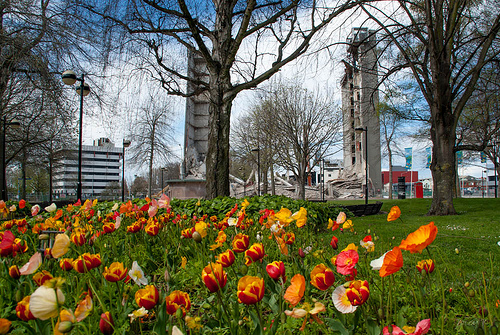

In [ ]:
img

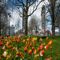

In [ ]:
img_resize = img.resize((60,60))
img_resize

In [ ]:
#Numpy array
img_array = tf.keras.preprocessing.image.img_to_array(img_resize)

In [ ]:
img_array.shape

(60, 60, 3)

In [ ]:
model.predict(img_array)

ValueError: ignored

In [ ]:
model.input

In [ ]:
tf.expand_dims(img_array, axis=0).shape

In [ ]:
model.output

In [ ]:
prediction = model.predict(tf.expand_dims(img_array, axis=0))

In [ ]:
tf.argmax(prediction[0])

In [ ]:
train_generator.class_indices